# **Machine Learning Terapan Final Project**

**Book Recommendation System**

Proyek ini berupa sistem rekomendasi buku dengan tujuan akhir yaitu mampu merekomendasikan buku kepada pengguna.   
Secara umum, sistem rekomendasi adalah algoritma yang ditujukan untuk menyarankan item yang relevan kepada pengguna (item seperti film untuk ditonton, buku untuk dibaca, produk untuk dibeli, atau apa pun tergantung pada industri).   
Dalam proyek ini, item yang disarankan adalah buku untuk dibaca dengan rincian dataset sebagai berikut :

1. *Users*  
  Berisi data pengguna. 
  - ID pengguna (User-ID) telah dianonimkan dan dipetakan ke bilangan bulat.  
  - Data demografis (Lokasi, Usia) jika tersedia. Jika tidak, bidang ini berisi nilai NULL.
  
2. *Books*  
  Berisi data buku.   
  - ISBN. ISBN yang tidak valid telah dihapus dari dataset. 
  - Judul Buku, Penulis Buku, Tahun Penerbitan, Penerbit, diperoleh dari Amazon Web Services. Dalam kasus beberapa penulis, hanya nama yang pertama disediakan. 
  - Gambar. URL yang tertaut ke gambar sampul juga diberikan (Image-URL-S, Image-URL-M, Image-URL-L), yaitu kecil, sedang, besar. URL ini mengarah ke situs web Amazon.  

3. *Ratings*  
Berisi informasi *rating* buku. 
  - *Rating (Book-Rating)* bersifat eksplisit, dinyatakan dalam skala 1-10 (nilai yang lebih tinggi menunjukkan apresiasi yang lebih tinggi) atau implisit, yang dinyatakan dengan 0.



https://www.kaggle.com/arashnic/book-recommendation-dataset

# Dataset

Langkah pertama adalah mengimpor dataset yang dibutuhkan. Dataset yang ada, bisa kita upload terlebih dahulu ke Google Drive agar lebih mudah diakses jika menggunakan device yang berbeda karena berbasis cloud.

In [ ]:
# Import the Dataset 

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Mengekstrak dataset dari bentuk zip

In [ ]:
# Extracting the Dataset

import zipfile,os
local_zip = '/content/drive/MyDrive/Dicoding/ML Final/Book Recommendation Dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Berikutnya adalah mengimpor libraries yang dibutuhkan

In [ ]:
# Importing Libraries

import numpy as np 
import pandas as pd 
from contextlib import contextmanager
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import correlation
from scipy.spatial.distance import correlation, cosine
from sklearn.metrics.pairwise import pairwise_distances
import ipywidgets as widgets
from IPython.display import display, clear_output
import os, sys
import re
from sklearn.metrics import mean_squared_error
from math import sqrt
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns
import missingno as mno 
import warnings
warnings.filterwarnings("ignore")

Selanjutnya adalah memuat dataset, yaitu Books, Ratings, dan Users

In [ ]:
# Load the dataset

Books = pd.read_csv('/content/drive/MyDrive/Dicoding/ML Final/Books.csv', low_memory=False)
ratings = pd.read_csv('/content/drive/MyDrive/Dicoding/ML Final/Ratings.csv', low_memory=False)
users = pd.read_csv('/content/drive/MyDrive/Dicoding/ML Final/Users.csv', low_memory=False)

In [ ]:
print(Books.shape)
print(ratings.shape)
print(users.shape)

(271360, 8)
(1149780, 3)
(278858, 3)


# Preliminary Exploration

Setelah mendapatkan dataset, selanjutnya mengekplorasi data terlebih dahulu untuk mendapatkan info mengenai data

In [ ]:
# Data Preliminary Exploration

Books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


Dari data diatas terlihat bahwa dataset Books berisi ISBN, Judul buku, Penulis, Tahun terbit, Penerbit, dan Image

In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


Dari data diatas terlihat bahwa dataset Ratings berisi User-ID, ISBN, dan Rating buku

In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


Dari data diatas terlihat bahwa dataset Users berisi User-ID, Lokasi, dan Umur pengguna

Selanjutnya adalah melihat isi dataset 

In [ ]:
Books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


# Exploratory Data Analysis

In [ ]:
Books.columns = ['ISBN', 'BookTitle', 'BookAuthor', 'YearOfPublication', 'Publisher', 'ImageUrlS', 'ImageUrlM', 'ImageUrlL']
ratings.columns = ['userID', 'ISBN', 'Book-Rating']
users.columns = ['userID', 'Location', 'Age']

Menghapus kolom yang tidak diperlukan dalam analisis, yaitu image

In [ ]:
# Dropping last three columns containing image URLs which will not be required for analysis

Books.drop(['ImageUrlS', 'ImageUrlM', 'ImageUrlL'],axis=1,inplace=True) 

Mengecek apakah ada missing value. Dari hasil diabawah terlihat bahwa tidak ada missing value d dataset Books

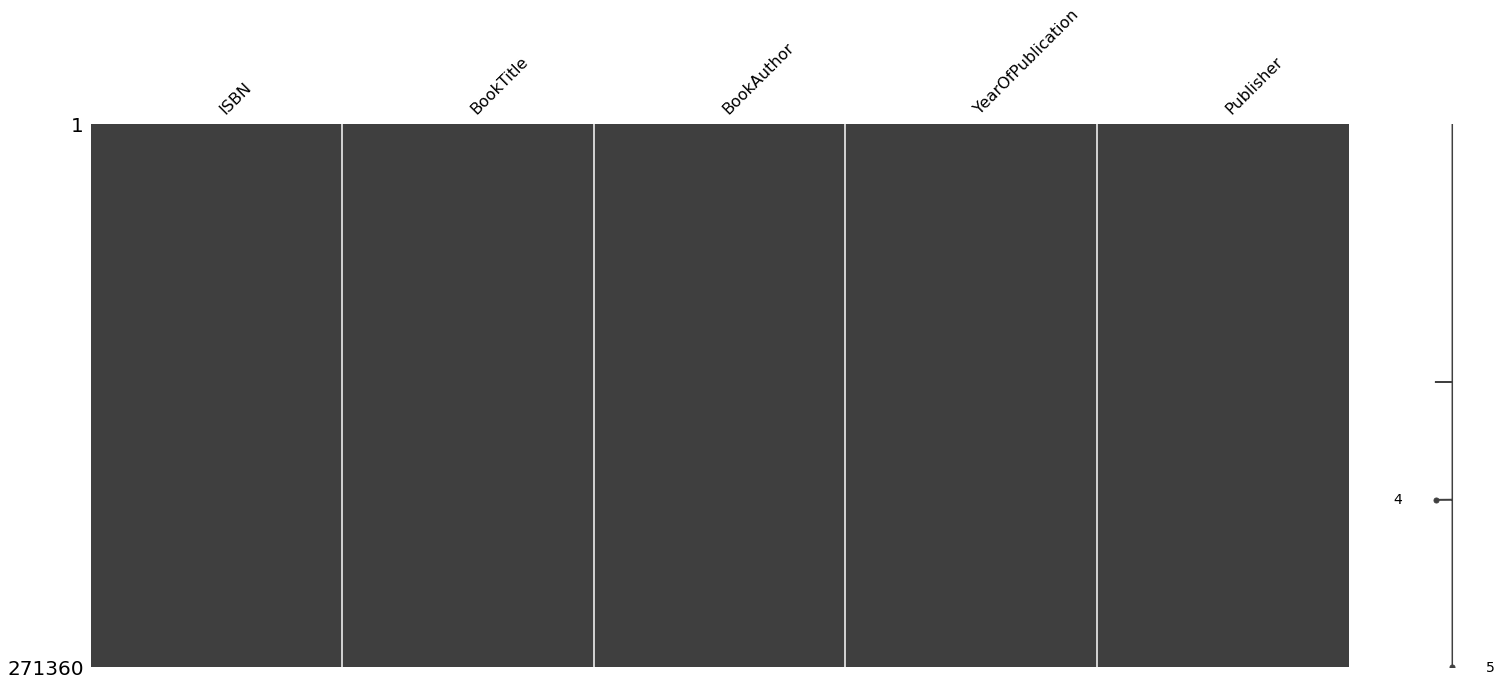

In [ ]:
# Visualize the missing values in the Books 

mno.matrix(Books)


Selanjutnya adalah mengecek apakah ada baris data yang terduplikat pada data Books. Dan dari 217360 baris data terlihat tidak ada baris yang terduplikat

In [ ]:
# Checking the existence of duplicated rows 

Books.duplicated().sum()

0

  Kita bisa memvisualisasikan penerbit teratas yang paling banyak menerbit buku. Dibawah ini adalah diagram 7 Penerbit Teratas 

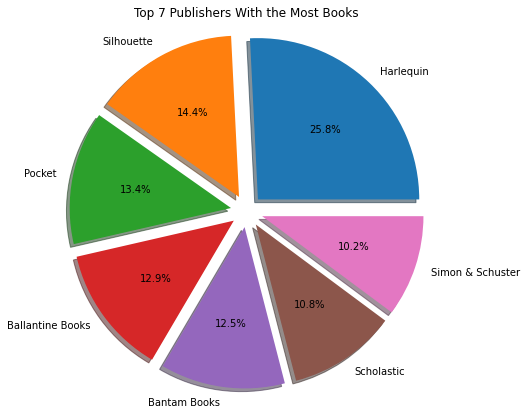

In [ ]:
# Plotting top publisher

top_publisher=(Books['Publisher'].value_counts()).to_dict()
count= pd.DataFrame(list(top_publisher.items()),columns = ['c','count'])
a = count.sort_values(by=['count'], ascending = False)
a.head(7)
labels = 'Harlequin','Silhouette','Pocket','Ballantine Books','Bantam Books','Scholastic','Simon & Schuster'
sizes = [count['count'].iloc[0],count['count'].iloc[1],count['count'].iloc[2],count['count'].iloc[3],count['count'].iloc[4],
         count['count'].iloc[5],count['count'].iloc[6]]
explode = (0.1, 0.1, 0.1, 0.1,0.1, 0.1,0.1 )
fig1 , ax1 = plt.subplots(figsize=(7,7))
ax1.pie(sizes,
        explode = explode,
        labels = labels,
        autopct = '%1.1f%%',
        shadow = True,
        startangle = 0)
plt.title("Top 7 Publishers With the Most Books")
ax1.axis ('equal')
plt.show()

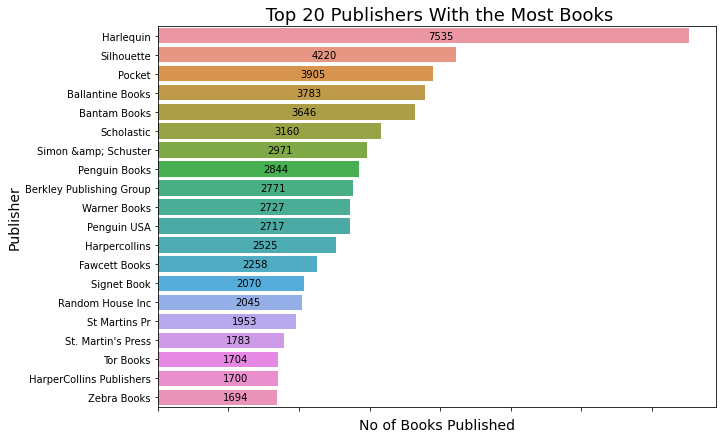

In [ ]:
b = count.sort_values(by=['count'], ascending = False)
b = b.head(20)
x =['Harlequin','Silhouette','Pocket','Ballantine Books','Bantam Books','Scholastic','Simon &amp; Schuster']
y = [7537,4220,3905,3783,3646,3160,2971]
fig=plt.figure(figsize=(10,7))
ax = sns.barplot(x = 'count',y = 'c' , data = b)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90,horizontalalignment='center')
plt.xlabel("No of Books Published", size=14)
plt.ylabel("Publisher", size=14)
plt.title(" Top 20 Publishers With the Most Books", size=18)
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), xy=(p.get_width()/2, p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")
plt.show()

# Data Preparation

Pada tahap Data Preparation, kita akan menyiapkan data dari masing-masing fitur, yaitu : ISBN, Judul Buku, Penulis, Rating buku, ID pengguna, Penerbit, dan Tahun terbit.    

Yang pertama adalah kita menggabungkan kolom ISBN yang ada pada dataset Books dan Ratings. Tujuannya adalah agar memudahkan proses mengolah data dan tidak ada data ISBN terduplikat

In [ ]:
# Merging dataframe Books and Ratings

Books_Ratings = pd.merge(Books, ratings, on="ISBN")

Sehingga kita menyebutnya sekarang adalah Books_Ratings 

In [ ]:
Books_Ratings.head()

,ISBN,BookTitle,BookAuthor,YearOfPublication,Publisher,userID,Book-Rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,2,0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,8,5
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,11400,0
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,11676,8
4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,41385,0


Selanjutnya adalah tahun terbit. 
Kita bisa mengecek terlebih dahulu apakah value dari tahun terbit sudah benar atau belum. 

In [ ]:
# Checking Year-Of-Publication values

np.set_printoptions(threshold=np.inf)
Books_Ratings['YearOfPublication'].unique()

array(['2002', '2001', '1991', '1999', '2000', '1993', '1996', '1988',
       '2004', '1998', '1994', '2003', '1997', '1983', '1979', '1995',
       '1982', '1985', '1992', '1986', '1978', '1980', '1952', '1987',
       '1990', '1981', '1989', '1984', '0', '1968', '1961', '1958',
       '1974', '1976', '1971', '1977', '1975', '1965', '1941', '1970',
       '1962', '1973', '1972', '1960', '1966', '1920', '1956', '1959',
       '1953', '1951', '1942', '1963', '1964', '1969', '1954', '1950',
       '1967', '2005', '1957', '1940', '1937', '1955', '1946', '1936',
       '1930', '2011', '1925', '1948', '1943', '1947', '1945', '1923',
       '2020', '1939', '1926', '1938', '2030', '1911', '1904', '1949',
       '1932', '1928', '1929', '1927', '1931', '1914', '2050', '1934',
       '1910', '1933', '1902', '1924', '1921', '1900', '2038', '2026',
       '1944', '1917', '1901', '2010', '1908', '1906', '1935', '1806',
       '2021', '2012', '2006', 'DK Publishing Inc', 'Gallimard', '1909',
       

Dari hasil diatas terlihat bahwa ada wrong value, yaitu tahun yang seharusnya berisi angka malah berisikan tulisan (DK Publishing Inc, Gallimard). Selain itu juga ada wrong value yaitu tahun nya berisikan angka '0' dimana seharusnya berisikan 4 digit tahun. Lalu juga ada tahun yang tidak masuk akal yaitu 2024, 2026, 2030, 2037, 2038, dan 2050.

Mari kita selesaikan permasalahan diatas yaitu dengan mengkonversi wrong value tadi ke dalam 4 digit tahun sebagaimana mestinya

In [ ]:
# Convert wrong value to int in Year-Of-Publication

index=Books_Ratings.loc[Books_Ratings['YearOfPublication']=='DK Publishing Inc'].index
Books_Ratings.drop(index,inplace=True)
index=Books_Ratings.loc[Books_Ratings['YearOfPublication']=='Gallimard'].index
Books_Ratings.drop(index,inplace=True)
Books_Ratings['YearOfPublication'].unique()

array(['2002', '2001', '1991', '1999', '2000', '1993', '1996', '1988',
       '2004', '1998', '1994', '2003', '1997', '1983', '1979', '1995',
       '1982', '1985', '1992', '1986', '1978', '1980', '1952', '1987',
       '1990', '1981', '1989', '1984', '0', '1968', '1961', '1958',
       '1974', '1976', '1971', '1977', '1975', '1965', '1941', '1970',
       '1962', '1973', '1972', '1960', '1966', '1920', '1956', '1959',
       '1953', '1951', '1942', '1963', '1964', '1969', '1954', '1950',
       '1967', '2005', '1957', '1940', '1937', '1955', '1946', '1936',
       '1930', '2011', '1925', '1948', '1943', '1947', '1945', '1923',
       '2020', '1939', '1926', '1938', '2030', '1911', '1904', '1949',
       '1932', '1928', '1929', '1927', '1931', '1914', '2050', '1934',
       '1910', '1933', '1902', '1924', '1921', '1900', '2038', '2026',
       '1944', '1917', '1901', '2010', '1908', '1906', '1935', '1806',
       '2021', '2012', '2006', '1909', '2008', '1378', '1919', '1922',
       '1

In [ ]:
Books_Ratings.YearOfPublication=Books_Ratings.YearOfPublication.astype(np.int32)

# Setting invalid years as NaN
Books_Ratings.loc[(Books_Ratings.YearOfPublication > 2006) | (Books_Ratings.YearOfPublication == 0),'YearOfPublication'] = np.NAN

# Replacing NaNs with mean value of Year-Of-Publication
Books_Ratings.YearOfPublication.fillna(round(Books_Ratings.YearOfPublication.mean()), inplace=True)

Setelah memperbaiki value dari tahun terbit, selanjutnya kita bisa melihat apakah tahun nya sudah terisi dengan 4 digit angka dan ternyata sudah berhasil diubah

In [ ]:
# Recheck

Books_Ratings['YearOfPublication'].unique()

array([2002., 2001., 1991., 1999., 2000., 1993., 1996., 1988., 2004.,
       1998., 1994., 2003., 1997., 1983., 1979., 1995., 1982., 1985.,
       1992., 1986., 1978., 1980., 1952., 1987., 1990., 1981., 1989.,
       1984., 1968., 1961., 1958., 1974., 1976., 1971., 1977., 1975.,
       1965., 1941., 1970., 1962., 1973., 1972., 1960., 1966., 1920.,
       1956., 1959., 1953., 1951., 1942., 1963., 1964., 1969., 1954.,
       1950., 1967., 2005., 1957., 1940., 1937., 1955., 1946., 1936.,
       1930., 1925., 1948., 1943., 1947., 1945., 1923., 1939., 1926.,
       1938., 1911., 1904., 1949., 1932., 1928., 1929., 1927., 1931.,
       1914., 1934., 1910., 1933., 1902., 1924., 1921., 1900., 1944.,
       1917., 1901., 1908., 1906., 1935., 1806., 2006., 1909., 1378.,
       1919., 1922., 1897., 1376.])

Kita juga bisa memvisualisasikan data tahun terbit melalui histogram dari tahun terbit 1970 sampai dengan tahun 2021

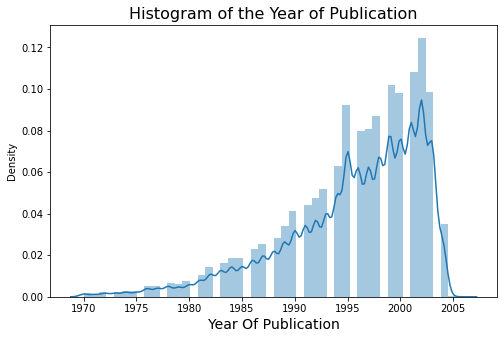

In [ ]:
# Plotting Years of Publication

fig=plt.figure(figsize=(8,5))
y1 = Books_Ratings[Books_Ratings['YearOfPublication'] >= 1970]
y1 = y1[y1['YearOfPublication'] <= 2021]
sns.distplot(y1['YearOfPublication'])
plt.xlabel('Year Of Publication',size=14)
plt.title('Histogram of the Year of Publication',size=16)
plt.show()

Dari histogram diatas, tahun paling populer dalam penerbitan buku adalah antara tahun 2000-2005

Fitur selanjutnya adalah rating buku. Rating bersifat eksplisit dinyatakan dalam skala 1-10 (nilai yang lebih tinggi menunjukkan apresiasi yang lebih tinggi) atau implisit, yang dinyatakan dengan 0.

**Ratings Dataset**

In [ ]:
ratings['Book-Rating'].unique()

array([ 0,  5,  3,  6,  8,  7, 10,  9,  4,  1,  2])

In [ ]:
# Checking rows

ratings.head()

,userID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [ ]:
# Ratings dataset should have books only which exist in our books dataset, unless new books are added to books dataset

ratings_new = ratings[ratings.ISBN.isin(Books.ISBN)]

ratings = ratings[ratings.userID.isin(users.userID)]

print(ratings.shape)
print(ratings_new.shape)

(1149780, 3)
(1031136, 3)


Lalu kita memisahkan rating eksplisit dan implisit karena kita hanya akan menggunakan yang eksplisit (dimulai dari 1) dan bukan implisit (0)

In [ ]:
# Segragating implicit and explicit ratings datasets

ratings_explicit = ratings_new[ratings_new['Book-Rating'] != 0]
ratings_implicit = ratings_new[ratings_new['Book-Rating'] == 0]

In [ ]:
# Checking shapes

print(ratings_new.shape)
print(ratings_explicit.shape)
print(ratings_implicit.shape)

(1031136, 3)
(383842, 3)
(647294, 3)


Dan kita memvisualisasikan rating buku untuk melihat angka berapa yang sering pengguna berikan dalam menilai buku

(1149780, 3)
(383842, 3)
(647294, 3)


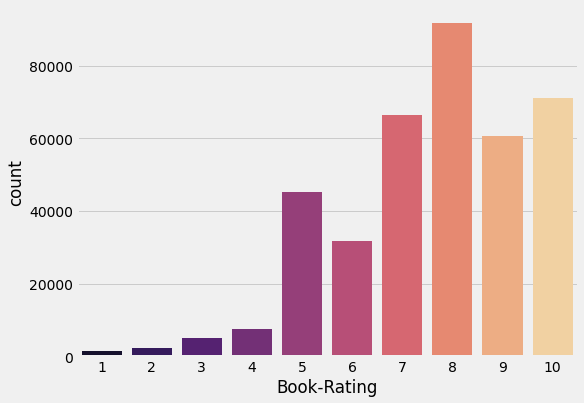

In [ ]:
print(ratings.shape)
print(ratings_explicit.shape)
print(ratings_implicit.shape)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 6))
sns.countplot(data=ratings_explicit , x='Book-Rating', palette='magma')

Selanjutnya kita mengidentifikasi data Users

**Users Dataset**

In [ ]:
users.head()

,userID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


Terlihat di bagian 'Age' masih ada missing value. Kita akan melihat lebih jauh data umur dari pengguna

In [ ]:
users['Age'].unique()

array([ nan,  18.,  17.,  61.,  26.,  14.,  25.,  19.,  46.,  55.,  32.,
        24.,  20.,  34.,  23.,  51.,  31.,  21.,  44.,  30.,  57.,  43.,
        37.,  41.,  54.,  42.,  50.,  39.,  53.,  47.,  36.,  28.,  35.,
        13.,  58.,  49.,  38.,  45.,  62.,  63.,  27.,  33.,  29.,  66.,
        40.,  15.,  60.,   0.,  79.,  22.,  16.,  65.,  59.,  48.,  72.,
        56.,  67.,   1.,  80.,  52.,  69.,  71.,  73.,  78.,   9.,  64.,
       103., 104.,  12.,  74.,  75., 231.,   3.,  76.,  83.,  68., 119.,
        11.,  77.,   2.,  70.,  93.,   8.,   7.,   4.,  81., 114., 230.,
       239.,  10.,   5., 148., 151.,   6., 101., 201.,  96.,  84.,  82.,
        90., 123., 244., 133.,  91., 128.,  94.,  85., 141., 110.,  97.,
       219.,  86., 124.,  92., 175., 172., 209., 212., 237.,  87., 162.,
       100., 156., 136.,  95.,  89., 106.,  99., 108., 210.,  88., 199.,
       147., 168., 132., 159., 186., 152., 102., 116., 200., 115., 226.,
       137., 207., 229., 138., 109., 105., 228., 18

Dari hasil diatas, ternyata selain NaN, ada juga umur yang kurang masuk akal yaitu dibawah 5 tahun dan diatas 90 tahun bahkan sampai umur 200an tahun. Maka seperti tahun terbit tadi, kita akan mengubah nya menjadi NaN dan kemudian NaN akan diubah menjadi nilai rata-rata dari Age. 

In [ ]:
# Setting invalid Age as NaN
users.loc[(users.Age < 5) | (users.Age > 90),'Age'] = np.NAN

# Replacing NaNs with mean value of Age
users.Age.fillna(round(users.Age.mean()), inplace=True)

users.Age=users.Age.astype(np.int32)


In [ ]:
# Recheck Age

users['Age'].unique()

array([35, 18, 17, 61, 26, 14, 25, 19, 46, 55, 32, 24, 20, 34, 23, 51, 31,
       21, 44, 30, 57, 43, 37, 41, 54, 42, 50, 39, 53, 47, 36, 28, 13, 58,
       49, 38, 45, 62, 63, 27, 33, 29, 66, 40, 15, 60, 79, 22, 16, 65, 59,
       48, 72, 56, 67, 80, 52, 69, 71, 73, 78,  9, 64, 12, 74, 75, 76, 83,
       68, 11, 77, 70,  8,  7, 81, 10,  5,  6, 84, 82, 90, 85, 86, 87, 89,
       88], dtype=int32)

Dari hasil diatas, data Umur sudah terlihat lebih bagus dan masuk akal

# Data Modelling 

Pada pemodelan, kita akan menggunakan metode Collaborative Filtering dengan pendekatan Item Based dan User Based menggunakan algoritma K-Nearest Neighbors

**Collaborative Filtering Based Recommendation System** 

Setelah data sudah selesai dipersiapkan, maka selanjutnya adalah memasuki proses pemodelan. 
Selanjutnya kita menggunakan Collaborative Filtering dengan algoritma K-Nearest Neighbours. Algoritma KNN menggunakan ‘kesamaan fitur’ untuk memprediksi nilai dari setiap data yang baru. Dengan kata lain, setiap data baru diberi nilai berdasarkan seberapa mirip titik tersebut dalam set pelatihan.

Karena data buku nya sangat banyak dan bisa mempengaruhi kinerja model, maka kita perkecil ruang lingkup dengan memakai variabel rating explicit yang sudah kita definisikan di Data Preparation tadi. Ruang lingkup nya yaitu rating explicit dari pengguna yang sudah memberikan rating terhadap minimal 100 buku serta buku yang sudah dirating sebanyak minimal 200 kali, sehingga ruang lingkup nya menjadi lebih kecil untuk melatih model 

In [ ]:
counts_new = ratings_explicit['userID'].value_counts()
ratings_explicit = ratings_explicit[ratings_explicit['userID'].isin(counts_new[counts_new >= 100].index)]
counts = ratings_explicit['Book-Rating'].value_counts()
ratings_explicit = ratings_explicit[ratings_explicit['Book-Rating'].isin(counts[counts >= 200].index)]

Selanjutnya adalah membuat matriks rating dari rating explicit dan mengatasi NaN values

In [ ]:
matrix_ratings = ratings_explicit.pivot(index='userID', columns='ISBN', values='Book-Rating')
userID = matrix_ratings.index
ISBN = matrix_ratings.columns
print(matrix_ratings.shape)
matrix_ratings.fillna(0, inplace = True)
matrix_ratings = matrix_ratings.astype(np.int32)
matrix_ratings.head()

(449, 66574)


ISBN,0000913154,0001046438,000104687X,0001047213,0001047973,000104799X,0001048082,0001053736,0001053744,0001055607,0001056107,0001845039,0001935968,0001944711,0001952803,0001953877,0002000547,0002005018,0002005050,0002005557,0002006588,0002115328,0002116286,0002118580,0002154900,0002158973,0002163713,0002176181,0002176432,0002179695,0002181924,0002184974,0002190915,0002197154,0002223929,0002228394,000223257X,0002233509,0002239183,0002240114,...,987960170X,9974643058,999058284X,9992003766,9992059958,9993584185,9994256963,9994348337,9997405137,9997406567,9997406990,999740923X,9997409728,9997411757,9997411870,9997412044,9997412958,9997507002,999750805X,9997508769,9997512952,9997519086,9997555635,9998914140,B00001U0CP,B00005TZWI,B00006CRTE,B00006I4OX,B00007FYKW,B00008RWPV,B000092Q0A,B00009EF82,B00009NDAN,B0000DYXID,B0000T6KHI,B0000VZEJQ,B0000X8HIE,B00013AX9E,B0001I1KOG,B000234N3A
userID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2033,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2110,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2276,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4017,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4385,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Menentukan variabel global dimana parameter k kita beri nilai 10 

In [ ]:
global metric,k
k=10
metric='cosine'

**User Based Recommendation System**

Pada model KNN ini, kita memakai 2 pendekatan yaitu User based dan Item based.  User based adalah pendekatan yang menghasilkan rekomendasi dari pengguna lain yang memiliki selera yang sama.  
Dengan menggunakan algortime "brute" untuk mencari tetangga terdekat dan mengepaskan model dengan mencari kesamaannya kepada buku serupa yang sudah diberi rating untuk direkomendasikan kepada pengguna. 

In [ ]:
def findksimilarusers(user_id, ratings, metric = metric, k=k):
    similarities=[]
    indices=[]
    model_knn = NearestNeighbors(metric = metric, algorithm = 'brute') 
    model_knn.fit(ratings)
    loc = ratings.index.get_loc(user_id)
    distances, indices = model_knn.kneighbors(ratings.iloc[loc, :].values.reshape(1, -1), n_neighbors = k+1)
    similarities = 1-distances.flatten()
            
    return similarities,indices

Selanjutnya adalah kita mencoba mencari prediksi rating dari sebuah buku kepada pengguna. Matriks rating yang tadi sudah kita buat akan digunakan dalam training prediksi ini. Format nya adalah User ID, Item ID (buku) dan prediksi rating. Dimana matriks nya tadi juga didesain serupa, yaitu User ID, nomor ISBN, dan rating buku. Sehingga dengan memanfaatkan matriks rating tersebut kita bisa memprediksi rating buku. 

In [ ]:
def predict_userbased(user_id, item_id, ratings, metric = metric, k=k):
    prediction=0
    user_loc = ratings.index.get_loc(user_id)
    item_loc = ratings.columns.get_loc(item_id)
    similarities, indices=findksimilarusers(user_id, ratings,metric, k) 
    mean_rating = ratings.iloc[user_loc,:].mean() 
    sum_wt = np.sum(similarities)-1
    product=1
    wtd_sum = 0 
    
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i] == user_loc:
            continue;
        else: 
            ratings_diff = ratings.iloc[indices.flatten()[i],item_loc]-np.mean(ratings.iloc[indices.flatten()[i],:])
            product = ratings_diff * (similarities[i])
            wtd_sum = wtd_sum + product
    
    if prediction <= 0:
        prediction = 1   
    elif prediction >10:
        prediction = 10
    
    prediction = int(round(mean_rating + (wtd_sum/sum_wt)))
    print ("Predicted rating for user {0} -> item {1}: {2}".format(user_id,item_id,prediction))

    return prediction


Dari hasil dibawah terlihat bahwa buku ber-ISBN : 0060938455 diprediksi rating nya kepada pengguna dengan User ID 105979 dan 11676, masing-masing 1 dan 2. Semakin besar hasil prediksi rating diharapkan bisa menjadi rekomendasi kepada pengguna.

In [ ]:
predict_userbased(105979,'0060938455',matrix_ratings);
predict_userbased(11676,'0060938455',matrix_ratings);

Predicted rating for user 105979 -> item 0060938455: 1
Predicted rating for user 11676 -> item 0060938455: 2


**Item Based Recommendation System** 

Pendekatan selanjutnya adalah dengan Item Based. Item based filtering bekerja dengan cara menghitung kesamaan antara masing-masing item. Jika user based adalah rekomendasi berdasarkan kesamaan pengguna, maka item based adalah rekomendasi berdasarkan kesamaan item. 

Kita akan melakukan hal yang sama seperti pada user based yaitu mencari kesamaan (similarities).

In [ ]:
def findksimilaritems(item_id, ratings, metric=metric, k=k):
    similarities=[]
    indices=[]
    ratings=ratings.T
    loc = ratings.index.get_loc(item_id)
    model_knn = NearestNeighbors(metric = metric, algorithm = 'brute')
    model_knn.fit(ratings)
    
    distances, indices = model_knn.kneighbors(ratings.iloc[loc, :].values.reshape(1, -1), n_neighbors = k+1)
    similarities = 1-distances.flatten()

    return similarities,indices

Kita akan menguji dengan mencari kesamaan pada item yang memiliki ISBN 0060938455

In [ ]:
similarities,indices=findksimilaritems('0060938455',matrix_ratings)

Selanjutnya kita nenbuat prediksi dengan menggunakan matriks rating yang kita buat tadi dan item ID (nomor ISBN). Format prediksi nya sama seperti tadi yaitu User ID, nomor ISBN, dan prediksi rating. Perbedaan dalam mencari prediksi rating dari user based dan item based adalah dalam user based, prediksi rating yang diberikan juga dipengaruhi oleh nilai rating dikurangi rata-rata rating karena untuk mencari item yang direkomendasikan, user based mengambil data rata-rata dari pengguna lain yang memberikan rating pada buku. Sedangkan pada item based hanya dipengaruhi oleh rating buku karena lebih berfokus pada kesamaan item.

In [ ]:
def predict_itembased(user_id, item_id, ratings, metric = metric, k=k):
    prediction= wtd_sum =0
    user_loc = ratings.index.get_loc(user_id)
    item_loc = ratings.columns.get_loc(item_id)
    similarities, indices=findksimilaritems(item_id, ratings) 
    sum_wt = np.sum(similarities)-1
    product=1
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i] == item_loc:
            continue;
        else:
            product = ratings.iloc[user_loc,indices.flatten()[i]] * (similarities[i])
            wtd_sum = wtd_sum + product                              
    prediction = int(round(wtd_sum/sum_wt))
    
    if prediction <= 0:
        prediction = 1   
    elif prediction >10:
        prediction = 10
 
    print ("Predicted rating for user {0} -> item {1}: {2}".format(user_id,item_id,prediction))     
    
    return prediction

Kita akan mencoba Item Based dengan ISBN yang sama digunakan tadi dan dengan user ID yang sebelumnya jga kita gunakan dengan masing-masing prediksi rating 1 dan 9. 

In [ ]:
predict_itembased(105979,'0060938455',matrix_ratings);
predict_itembased(11676,'0060938455',matrix_ratings);

Predicted rating for user 105979 -> item 0060938455: 1
Predicted rating for user 11676 -> item 0060938455: 9


In [ ]:
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

Selanjutnya adalah memberikan rekomendasi kepada user berdasarkan pendekatan User based atau Item based. 
Pada dasarnyya ini adalah satu model yaitu KNN namun menggunakan 2 pendekatan yang berbeda tergantung kebutuhan. Jika ingin memberikan rekomendasi berdasarkan apa buku yang juga dibaca oleh orang lain, maka menggunakan User based. Namun jika ingin mencari buku yang serupa maka menggunakan Item based.   

Untuk metrik yang digunakan juga menggunakan 2 metrik yaitu cosine dan correlation. Cosine adalah metrik yang digunakan untuk menghitung kesamaan dalam 2 sampel sedangkan correlation menghitung korelasi antar 2 variabel acak. 

In [ ]:
def recommendItem(user_id, ratings, metric=metric):    
    if (user_id not in ratings.index.values) or type(user_id) is not int:
        print ("User id should be a valid integer from this list :\n\n {} ".format(re.sub('[\[\]]', '', np.array_str(matrix_ratings.index.values))))
    else:    
        ids = ['Item-based (correlation)','Item-based (cosine)','User-based (correlation)','User-based (cosine)']
        select = widgets.Dropdown(options=ids, value=ids[0],description='Select approach', width='1000px')
        def on_change(change):
            clear_output(wait=True)
            prediction = []            
            if change['type'] == 'change' and change['name'] == 'value':            
                if (select.value == 'Item-based (correlation)') | (select.value == 'User-based (correlation)') :
                    metric = 'correlation'
                else:                       
                    metric = 'cosine'   
                with suppress_stdout():
                    if (select.value == 'Item-based (correlation)') | (select.value == 'Item-based (cosine)'):
                        for i in range(ratings.shape[1]):
                            if (ratings[str(ratings.columns[i])][user_id] !=0): #not rated already
                                prediction.append(predict_itembased(user_id, str(ratings.columns[i]) ,ratings, metric))
                            else:                    
                                prediction.append(-1) #for already rated items
                    else:
                        for i in range(ratings.shape[1]):
                            if (ratings[str(ratings.columns[i])][user_id] !=0): #not rated already
                                prediction.append(predict_userbased(user_id, str(ratings.columns[i]) ,ratings, metric))
                            else:                    
                                prediction.append(-1) #for already rated items
                prediction = pd.Series(prediction)
                prediction = prediction.sort_values(ascending=False)
                recommended = prediction[:10]
                print ("As per {0} approach....Following books are recommended...".format(select.value))
                for i in range(len(recommended)):
                     print ("{0}. {1}".format(i+1,Books.BookTitle[recommended.index[i]].encode('utf-8')))                        
        select.observe(on_change)
        display(select)

In [ ]:
recommendItem(10000, matrix_ratings)

User id should be a valid integer from this list :

   2033   2110   2276   4017   4385   5582   6242   6251   6543   6575
   7286   7346   8067   8245   8681   8890  10560  11676  11993  12538
  12824  12982  13552  13850  14422  15408  15418  16634  16795  16966
  17950  19085  21014  23768  23872  23902  25409  25601  25981  26535
  26544  26583  28591  28634  29259  30276  30511  30711  30735  30810
  31315  31556  31826  32773  33145  35433  35836  35857  35859  36299
  36554  36606  36609  36836  36907  37644  37712  37950  38023  38273
  38281  39281  39467  40889  40943  43246  43910  46398  47316  48025
  48494  49144  49889  51883  52199  52350  52584  52614  52917  53220
  55187  55490  55492  56271  56399  56447  56554  56959  59172  60244
  60337  60707  63714  63956  65258  66942  67840  68555  69078  69389
  69697  70415  70594  70666  72352  73681  75591  75819  76151  76223
  76499  76626  78553  78783  78834  78973  79441  81492  81560  83287
  83637  83671  85526  85

Pada tahap ini, jika diimplementasikan hanya akan menggunakan satu pendekatan saja, item based atau user based. Tetapi karena kita ingin melihat perbedaan keduanya kita bisa mencoba pendekatan yang kita mau 

In [ ]:
recommendItem(105979, matrix_ratings)

As per Item-based (cosine) approach....Following books are recommended...
1. b'Ocean Apart'
2. b'Hawks: A Novel'
3. b'Encyclopedia Brown Takes the Case (Encyclopedia Brown (Paperback))'
4. b'Daisy Fay and the Miracle Man/Audio Cassette'
5. b"Wild at Heart: The South Island's West Coast"
6. b'Are You My Mother?'
7. b'Brazil'
8. b'Whip Hand'
9. b'The Half-Pipe Kidd'
10. b'Livre Secret Des Fourmis'


In [ ]:
recommendItem(105979, matrix_ratings)

As per User-based (cosine) approach....Following books are recommended...
1. b"I'll Be Watching You: A Novel"
2. b'Skull Session'
3. b'When You Eat at the Refrigerator, Pull Up a Chair : 50 Ways to Feel Thin, Gorgeous, and Happy (When You Feel Anything But)'
4. b"Beowulf's Children"
5. b'Self Matters : Creating Your Life from the Inside Out'
6. b'PENNY SAVED'
7. b'Matilda'
8. b'The Rubaiyat of Omar Khayyam (Dover Thrift Editions)'
9. b'The Prince and the Pauper'
10. b'What-A-Mess on the Beach'


Dari hasil diatas sudah terlihat jelas bahwa Item Based dan User Based menghasilkan rekomendasi yang berbeda meskipun menggunakan metrik yang sama karena item based dan user based mencari rekomendasi berdasarkan kebutuhan pengguna. 

In [ ]:
recommendItem(105979, matrix_ratings)

As per User-based (correlation) approach....Following books are recommended...
1. b"I'll Be Watching You: A Novel"
2. b'Skull Session'
3. b'When You Eat at the Refrigerator, Pull Up a Chair : 50 Ways to Feel Thin, Gorgeous, and Happy (When You Feel Anything But)'
4. b"Beowulf's Children"
5. b'Self Matters : Creating Your Life from the Inside Out'
6. b'PENNY SAVED'
7. b'Matilda'
8. b'The Rubaiyat of Omar Khayyam (Dover Thrift Editions)'
9. b'The Prince and the Pauper'
10. b'What-A-Mess on the Beach'


Sedangkan dari hasil diatas, User based yang menggunakan 2 metrik (cosine dan correlation) memperoleh rekomendasi yang sama. 

# Model Evaluation

Pada tahap evaluasi model, kita akan mengevaluasi model KNN dari pendekatan yang kita pilih atas user ID dan ISBN yang sama seperti sebelumnya.

In [ ]:
def evaluateRS(ratings):
    ids = ['User-based CF (cosine)','User-based CF (correlation)','Item-based CF (cosine)','Item-based CF (correlation)']
    approach = widgets.Dropdown(options=ids, value=ids[0],description='Select Approach', width='500px')
    n_users = ratings.shape[0]
    n_items = ratings.shape[1]
    prediction = np.zeros((n_users, n_items))
    prediction= pd.DataFrame(prediction)
    def on_change(change):
        clear_output(wait=True)
        with suppress_stdout():
            if change['type'] == 'change' and change['name'] == 'value':            
                if (approach.value == 'User-based CF (cosine)'):
                    metric = 'cosine'
                    for i in range(n_users):
                        for j in range(n_items):
                            prediction[i][j] = predict_userbased(105979, '0060938455', ratings, metric)
                elif (approach.value == 'User-based CF (correlation)')  :                       
                    metric = 'correlation'               
                    for i in range(n_users):
                        for j in range(n_items):
                            prediction[i][j] = predict_userbased(105979, '0060938455', ratings, metric)
                elif (approach.value == 'Item-based CF (cosine)'):
                    for i in range(n_users):
                        for j in range(n_items):
                            prediction[i][j] = predict_userbased(105979, '0060938455', ratings)
                else:
                    for i in range(n_users):
                        for j in range(n_items):
                            prediction[i][j] = predict_userbased(105979, '0060938455', ratings)
              
        MSE = mean_squared_error(prediction, ratings)
        RMSE = round(sqrt(MSE),3)
        print ("RMSE using {0} approach is: {1}".format(approach.value,RMSE))
              
    approach.observe(on_change)
    display(approach)

In [ ]:
evaluateRS(matrix_ratings)

RMSE using User-based CF (cosine) approach is: 0.472


Mungkin dikarenakan pada dasarnya hanyalah satu model saja yaitu KNN meskipun menggunakan pendekatan yang berbeda, model hanya bisa dievaluasi dari salah satu pendekatan. 
Saya sudah mencoba untuk mengevaluasi Item Based dan User Based namun model mengeluarkan hasil evaluasi hanya pada satu pendekatan saja. Sebaliknya jika saya memilih pendekatan lain, model tetap menghasilkan output evaluasi yang sama pada pendekatan yang dpilih sebelumnya. 